In [1]:
#!pip install pyabc
import pyabc as pyabc
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.visualization import plot_kde_2d, plot_data_callback
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
#import scipy as sp
from scipy.integrate import odeint
import math
import seaborn as sns
import pandas as pd
#pyabc.settings.set_figure_params('pyabc')  # for beautified plots
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test4.db"))



Fit the treated group data from 16:24h to estimate r and C

In [2]:
#Here we defien the ODE model (1)
def ode_model(contamination,t,r,C):
    Contamination = contamination;
    return(r*(1-Contamination/C))

#Here we create the input parameters and extract only specific time-points
def deterministic_run(parameters):#precision,initial_contamination,r,C,d,g):
    precision=5000
    tmax = 8
    time_space = np.linspace(0,tmax,precision+1)#precision+1?
    sim=odeint(ode_model,initial_contamination,time_space,args=(parameters["r"],parameters["C"]))
    #num_at_0=sim[int(precision*0.1/50.0)]
    #num_at_1=sim[int(precision*1/tmax)]
    num_at_2=sim[int(precision*2/tmax)]
    num_at_4=sim[int(precision*4/tmax)]
    num_at_6=sim[int(precision*6/tmax)]
    num_at_8=sim[int(precision*8/tmax)]
    #num_at_16=sim[int(precision*16/tmax)]
    #num_at_18=sim[int(precision*18/tmax)]
    #num_at_20=sim[int(precision*20/tmax)]
    #num_at_22=sim[int(precision*22/tmax)]
    #num_at_24=sim[int(precision*24/tmax)]
    #return{"Contamination":[num_at_2,num_at_4,num_at_6,num_at_16,num_at_18,num_at_20,num_at_22,num_at_24]}
    return{"Contamination":[num_at_2,num_at_4,num_at_6,num_at_8]}

# Define the parameter priors

We choose some examples to see how well it works.

In [3]:
parameter_prior = Distribution(r=RV("uniform", 0.0, 1.0),
                               C=RV("uniform", 5000.00, 10000.0))

parameter_prior.get_parameter_names()

['C', 'r']

# Define the distance fuction
This currently is a absolute distances between the two points divided by the standard deviation at each point. Could use Manhattan distance.

In [4]:
def distance(simulation, data):
    return np.absolute((data["Contamination"] - simulation["Contamination"])).sum()

# Set up the ABC SMC 


In [5]:
# We plug all the ABC options together and use an adaptive population size
from pyabc.populationstrategy import AdaptivePopulationSize


abc = ABCSMC(
    models=deterministic_run,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=AdaptivePopulationSize(1000, 0.15),
    # population_size=1000,
    transitions=LocalTransition(k_fraction=0.3),
    # eps=MedianEpsilon(500, median_multiplier=0.7),
)

INFO:Sampler:Parallelizing the sampling on 8 cores.


# Setting the observed data

In [6]:
# y_observed is the important piece here: our actual observation.
initial_contamination=400

#Assign y_observed to the ABCSMC object
measurement_data =np.array([644,1232,2033,2868])#  np.array([134.0,202.0,294.0]) #y_observed #

s=np.array([123,396,629,1147])#np.array([93.70165,86.13942,162.11107])#,116.61904,123.61230,396.88789,628.87201,1147.13556]) y_observed_sd #
precision=5000
measurement_times = np.array([18,20,22,24]) #np.array([2,4,6]) #np.array([2,4,6,16,18,20,22,24]) #


#This sets up the database and includes the measurement data and standard deviation
history = abc.new(db_path, {"Contamination": measurement_data,"sd":s})

INFO:History:Start <ABCSMC(id=21, start_time=2022-04-13 11:49:51.023978, end_time=None)>


# Running the ABC

In [7]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.1, max_nr_populations=15)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 20670.64609457046
INFO:ABC:t: 0, eps: 20670.64609457046.
INFO:ABC:Acceptance rate: 1000 / 1964 = 5.0916e-01, ESS=1.0000e+03.
INFO:Adaptation:Change nr particles 1000 -> 258
INFO:ABC:t: 1, eps: 20649.859092131523.
INFO:ABC:Acceptance rate: 258 / 643 = 4.0124e-01, ESS=2.4042e+02.
INFO:Adaptation:Change nr particles 258 -> 284
INFO:ABC:t: 2, eps: 20641.519433089878.
INFO:ABC:Acceptance rate: 284 / 621 = 4.5733e-01, ESS=2.6401e+02.
INFO:Adaptation:Change nr particles 284 -> 299
INFO:ABC:t: 3, eps: 20636.497424726404.
INFO:ABC:Acceptance rate: 299 / 645 = 4.6357e-01, ESS=2.6993e+02.
INFO:Adaptation:Change nr particles 299 -> 271
INFO:ABC:t: 4, eps: 20634.091573883725.
INFO:ABC:Acceptance rate: 271 / 638 = 4.2476e-01, ESS=2.4435e+02.
INFO:Adaptation:Change nr particles 271 -> 273
INFO:ABC:t: 5, eps: 20632.57873306057.
INFO:ABC:Acceptance rate: 273 / 643 = 4.2457e-01, ESS=2.4854e+02.
INFO:Adaptation:Change nr particles 27

# Visualise the probability density functions

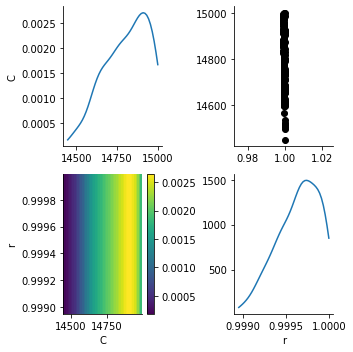

In [8]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w);

## Visualise how the parameters converge over populations

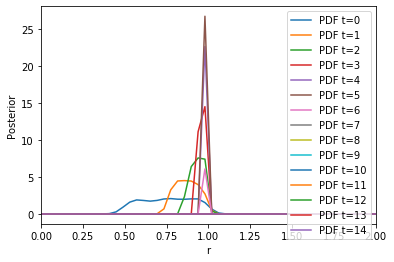

In [12]:
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=2,
        x="r",
        # xname=r"$\lambda$",
        ax=ax,
        label=f"PDF t={t}",
    )
#Add a vertical line at lambda=0.49 +- 0.32 to 0.72 
#This is the experimental value predicted in King et al. 2020 with Kalanne
ax.axvline(15, color="k", linestyle="dashed")
ax.legend();

# Summary statistics

First some summary statistics and save to file

In [13]:
df.to_csv("abc_results_second_half.csv", encoding='utf-8', index=False)
df.describe()

name,C,r
count,267.000000,267.000000
mean,14792.220850,0.999613
std,118.110942,0.000233
min,14447.431692,0.998949
25%,14709.575839,0.999457
50%,14787.936801,0.999644
75%,14884.309346,0.999783
max,14999.908862,0.999994


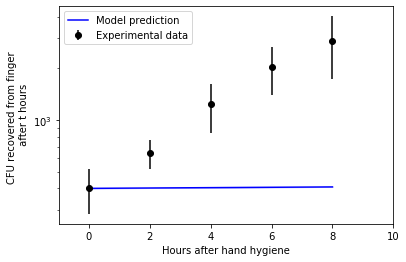

In [14]:
import pandas as pd
import operator


#plot some curves from the ODE model
precision=5000
tmax = 8
time_space = np.linspace(0,tmax,precision+1)#precision+1?

P=odeint(ode_model,initial_contamination,time_space,args=(df["r"].mean(),df["C"].mean()))
Pmin=odeint(ode_model,initial_contamination,time_space,args=(df["r"].quantile(0.05),df["C"].quantile(0.05)))
Pmax=odeint(ode_model,initial_contamination,time_space,args=(df["r"].quantile(0.95),df["C"].quantile(0.95)))

# create a vector of values between 0 and 6
x = np.array([0,2,4,6,8])

#Define new sd just for plotting to avoid SD value at 0
#s=np.array([385,93.70165,86.13942,162.11107])
#measurement_data = np.array([1200,134.0,202.0,294.0])
measurement_data =np.array([400,644,1232,2033,2868])
s=np.array([116,123,396,629,1147])
measurement_times = np.array([0,2,4,6,8]) 


#Plot errobars of experimental data

plt.errorbar(x,measurement_data,yerr=s,fmt='o', color='black',label='Experimental data')

#Plot the model prediction
plt.plot(time_space,P,label="Model prediction",color='blue')

#Plot confidence intervals around the model prediction

plt.fill_between(time_space,np.concatenate(Pmin),np.concatenate(Pmax),alpha=0.2,color='blue')
#plt.plot(time_space,Pmin,label="Model prediction",color='red')
#plt.plot(time_space,Pmax,label="Model prediction",color='red')

#plt.fill_between(x, np.array(map(operator.sub, P["Contamination"], Pmin["Contamination"])), np.array(map(operator.add, P["Contamination"], Pmax["Contamination"])), color='b', alpha=.1)
plt.xlim(-1,10)
plt.ylabel("CFU recovered from finger \n after t hours")
plt.yscale("log")
plt.xlabel("Hours after hand hygiene")
plt.legend(loc="upper left")
#make y axis logarithmic


#save the plot
#plt.savefig("../Images/abc_prediction.png", dpi=600)

plt.show()